# Active Learning and Multi-Arm Bandits

In this post, we are going to focus on two tasks, active learning - where we query the user/oracle to label samples; and the multi-arm bandit - where we again query the user/Oracle which returns us a scalar reward. We will be trying to pose the problems first and then talk about some of the ways to solve these problems.

The primary motivation behind active learning is the expensive cost of labeling in machine learning tasks.

## Mining Gold!

Let us explain the two problems using the gold mining application.
We will, for now, look at only one-dimensional locations, i.e., we are talking gold distribution only about a line.
The issue we have is that at the start of the activity, we have no idea about the amount of gold at different locations.
The only way we can get the information about the amount of gold is by drilling at a location.
This drilling is costly and involves expensive sensors to be used.
We, therefore, want to minimize the number of drillings that we require.

We below show two of the common objectives for the gold mining problem.

- **Problem 1: Best Estimate of Gold Distribution**
  In this problem, we are supposed to estimate the amount of gold on the one-dimensional line. But we can not drill at every location. We should drill at those locations that provide us the "maximum" information about the distribution of the gold.
  
- **Problem 2: Location of Maximum Gold**
  In this problem, we are supposed to find the location in the one-dimensional space where the gold quantity is the maximum. This problem focuses on finding the location with the most gold content.


![](active-gp.gif)

---

![](MAB_gifs/mab-gp-pi-eps0.5.gif)

- Here are representative animations showing the process of drilling at new locations and to reduce the uncertainty and get the best predictions showcasing the Active Learning problem.

- And drilling at locations to get the location of the maximum gold reserve, showcasing the Multi Armed Bandit problem

We will build the solution to both of these problems from the ground up.

#### Some imports

In [1]:
import os
import warnings
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.special import ndtr
from scipy.stats import norm

warnings.filterwarnings('ignore')
%matplotlib inline

#### Prettyfing Matplotlib plots

In [2]:
SPINE_COLOR = 'gray'

def format_axes(ax):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### Active Learning

**Problem 1** is very similar to problems we like to solve using active learning. Active learning is used to predict distribution by reducing uncertainty. One of the ways we can reduce the uncertainty is by choosing the point at which we have the maximum variance (we are most uncertain).

### Gaussian Processes

In our previous post, [here](GP-1.html); we had introduced the Gaussian Process. As you can remember, we use Gaussian Processes to get a prediction as well as the attached uncertainty (variance) with that prediction. This will turn out to be useful for us, as we wanted to drill where we were most uncertain. By using Gaussian processes, we take some very naive assumption that the gold distribution of nearby points in similar (smoothness).

#### Creating ground truth data

In [3]:
def f(x):
    """The function to predict."""
    return 2*((x-3)*np.sin((x-3))) + 2 + 0.5*x

Let us now try to see how our groundtruth data looks like.

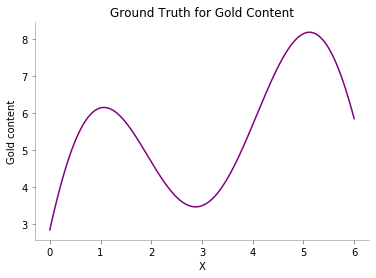

In [4]:
x = np.atleast_2d(np.linspace(0, 6, 600)).T
plt.plot(x, f(x), color='purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.title("Ground Truth for Gold Content")
format_axes(plt.gca())
plt.savefig('MAB_gifs/GT.svg', bbox_inches="tight")

#### Prior Model

Our prior model doesn't know much and assumes a smooth relationship between points via an Matern kernel. The Grey line in the graph below denotes the knowledge we have about the gold content without drilling even at a single location.

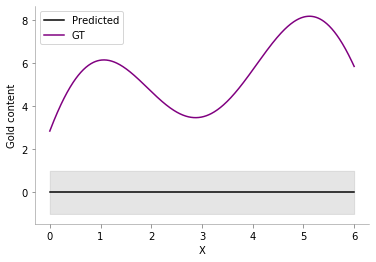

In [5]:
kernel = Matern(length_scale=1.0)
# kernel = None
gp = GaussianProcessRegressor(kernel=kernel)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted', lw=1.5)
plt.plot(x, f(x), 'purple', label='GT', lw=1.5)
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2)
plt.legend()
format_axes(plt.gca())
plt.savefig('MAB_gifs/prior.svg', bbox_inches="tight")

Also, take notice that the confidence (uncertainty) about the gold content is also the same for every location.

####  Adding Training Data
Let us now add a point to the train set or in other words, drill one of the locations and see the gold content (`y`). We can see how our confidence and our estimates change after we get this first information by fitting the model to the new data. I am going to add `(x = 0.5, y = f(0.5))` into the train set now.

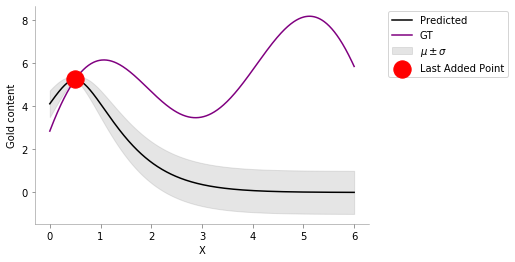

In [6]:
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted')
plt.plot(x, f(x), 'purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=300, zorder=10, label='Last Added Point')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
format_axes(plt.gca())
plt.savefig('MAB_gifs/posterior.svg', bbox_inches="tight")

Nice! We see now that the posterior has changed and we are very certain about the gold content in the vicinity of `x = 0.5`, but, very uncertain far away from it. Also, we can see that the mean of the point closer to `x = 0.5` is closer to the value that we got from drilling and seeing the gold content. So, we now come to the key idea.

#### Active Learning Procedure

1. Choose the point of having the highest uncertainty
2. Add the point to train set
3. Train on the new train set
4. Go to 1 till convergence or budget elapsed

In [7]:
# Stopping criteria is 10 iterations
for i in range(10):
    # Fit on current train set
    gp.fit(train_X, train_y.flatten())
    # predict on current pool set
    y_pred, sigma = gp.predict(x, return_std=True)
    plt.plot(x, y_pred, 'k', label='Predicted')
    plt.plot(x, f(x), 'purple', label='GT')
    plt.xlabel("X")
    plt.ylabel("Gold content")
    plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
    plt.scatter(train_X[:-1], train_y[:-1], color='black', s=300, zorder=10, label='Train points')
    plt.scatter(train_X[-1], train_y[-1], color='red', s=300, zorder=10, label='Query Point')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title(f"Iteration: {i}")
    format_axes(plt.gca())
    plt.ylim((1, 9))
    plt.xlim((-1, 7))
    dirName = 'active-gp-img'
    os.makedirs(dirName, exist_ok=True)
    plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=300)
    plt.close()
    
    # Choose the next point with highest sigma
    next_ix = np.argmax(sigma)
    next_x = x[next_ix]
    # Add new point with highest uncertainty to the pool set
    train_X = np.vstack([train_X, [x[next_ix]]])
    train_y = f(train_X)

Let us now automate this process and see how our posterior changes at every iteration where we add a sensor. For each of our iteration below, the prior was the Gaussian Process learned on the points already in the training set. We have recreated the 1st animation at the top of the post!

In [8]:
!convert -delay 40 -loop 0 active-gp-img/*.png MAB_gifs/active-gp.gif

![](MAB_gifs/active-gp.gif)

There you go we have recreated one of the plots from the starting of the blog! One point to notice is that this idea of choosing the most uncertain location leads to querying of the points that are the farthest (visible when we choose the 2nd location to drill). This might not be so good as we are kind of wasting our drillings because they are at the boundary of the 1-dimensional plot.

----

### Multi-Armed Bandit

**Problem 2** requires us to find the location where the gold content is maximum. Even though the problem setting may be similar, the objective is quite different than problem 1. In other words, we just want the location where we can drill to get the most gold.

Older problem - Earlier in the active learning problem, our motivation for drilling at locations was to predict the distribution of the gold content over all the locations in the one-dimensional line. We, therefore, had chosen the next location to drill where we had maximum uncertainty about our estimate.

In this problem, we are instead interested to know the location at which we find the maximum gold. For getting the location of maximum gold content, we might want to drill at the location where predicted mean is the highest (exploit). But unfortunately our mean is not always accurate, so we need to correct our mean (reduce variance / explore) too. Multi-Arm Bandit looks at both exploitation and exploration, whereas in the case of Active Learning Problem, we only cared about exploration.

#### Acquisition Functions

Now, to take into account the combination of exploration and exploitation, we try to use a function which combines the two sides. These utility functions that take into account both exploration and exploitation in multi-arm bandit problem are called acquisition functions.

In [9]:
class ACQ:
    def acq_fn(self, *args, **kwargs):
        raise NotImplemented
    def __str__(self):
        return self.__class__.__name__
    def __call__(self, *args, **kwargs):
        return self.acq_fn(*args, **kwargs)

class ACQ1(ACQ):
    def acq_fn(self, gp_reg, x, lam = 0.4, **kwrags):
        """
        gp_reg: sklearn.GPRegresssor
        lam: float, where the objective is: \mu(x) + \lambda \sigma(x)
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        return y_pred + lam*sigma

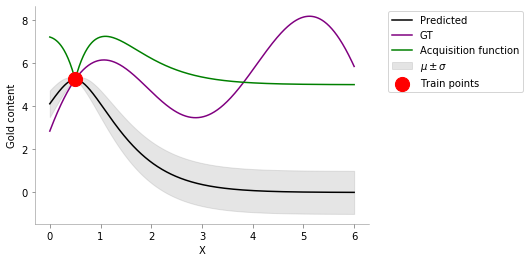

In [10]:
acq_obj = ACQ1()

train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()
gp.fit(train_X, train_y)
y_pred, sigma = gp.predict(x, return_std=True)
plt.plot(x, y_pred, 'k', label='Predicted')
plt.plot(x, f(x), 'purple', label='GT')
plt.xlabel("X")
plt.ylabel("Gold content")
plt.fill_between(x.flatten(), y_pred+sigma, y_pred-sigma, color='gray', alpha=0.2, label=r'$\mu \pm \sigma$')
plt.scatter(train_X, train_y, color='red', s=200, zorder=10, label='Train points')
plt.plot(x, acq_obj(gp, x, 5), label='Acquisition function', color='green')
format_axes(plt.gca())
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig(f"MAB_gifs/acq_fn.svg", bbox_inches="tight")

Here, we can see that mean near the location of the just added point (red point) is high. But as we go far from the red point, we see that our uncertainty increases to a maximum. As we discussed in multi-arm bandit problem, we like to have some combination of exploration and exploitation. The most basic way to do so is by linearly combining the two values.

### ACQ1

This combined value that takes into account exploration and exploitation is referred to as the acquisition value, returned by acquisition function. We see at around the location `x = 1.4` we get the maximum value for the acquisition (green curve). Thus we next select this location to drill.

The intuition of using the acquisition function `mean + lam * uncertainty` is that we are interested in finding the global mean, so taking into account the estimated mean would be a good idea. Additionally, we would like to explore too (using `lam`); else we might be stuck in a local minimum if don't explore too much (see below).

We define a big plotting function below for saving us the trouble down the road.

In [11]:
def rargmax(b):
    """Randomly tie breaking argmax"""
    return np.random.choice(np.flatnonzero(b == b.max()))

def plot_acquisition(
        train_X, train_y,
        acq_class, acq_params={},
        ylim0=None, xlim0=None,
        ylim1=None, xlim1=None,
        y1scale='linear', it = 10,
        seed = 2
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(nrows=2, sharex=True)
        ax[1].set_yscale(y1scale)
        
        # limits
        ax[0].set_ylim(ylim0) if ylim0 is not None else ax[0].set_ylim(min(f(x)-.5), max(f(x))+.5)
        ax[0].set_xlim(xlim0) if xlim0 is not None else ax[0].set_xlim(min(x)-.5, max(x)+.5)
        ax[1].set_ylim(ylim1) if ylim1 is not None else None
        ax[1].set_xlim(xlim1) if xlim1 is not None else ax[1].set_xlim(min(x)-.5, max(x)+.5)
        
        # fitting
        gp.fit(train_X, train_y.flatten())
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, x, t=i+1, **acq_params, mu=max(train_y))
        ax[1].plot(x, acquisition, label='Acquisition function', color='green')
        
        # predict on current pool set
        y_pred, sigma = gp.predict(x, return_std=True)
        ax[0].plot(x, y_pred, 'k', label='Predicted')
        ax[0].plot(x, f(x), 'purple', label='GT')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Gold content")
        ax[0].fill_between(x.flatten(), y_pred+sigma,
                           y_pred-sigma, color='gray',
                           alpha=0.2, label=r'$\mu \pm \sigma$')
        ax[0].scatter(train_X, train_y, color='black', s=100,
                      zorder=10, label='Train points')
        ax[0].legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax[1].set_ylabel(str(acq_obj))
        hyperparams = ' | '.join([str(k)+': '+str(v) for k, v in acq_params.items()])
        ax[0].set_title(f"Iteration: {i} & HParam(s) → " + hyperparams)
        
        # Choose the next point with highest sigma
        max_mu = max(train_y)
        max_till_now.append(max_mu)
        next_ix = rargmax(acquisition)
        next_x = x[next_ix]

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(x[next_ix], acquisition[next_ix], marker='X',s=50,
                      c='orange', zorder=10, label='maxima (tie randomly broken)')
        ax[0].scatter(x[next_ix], f(x[next_ix]), color='red',
                      s=200, zorder=-10, label='Query Point')
        ax[0].legend(bbox_to_anchor=(1.1,1), loc="upper left")
        ax[1].legend(bbox_to_anchor=(1.1,0.5), loc="upper left")
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)
        format_axes(ax[0])
        format_axes(ax[1])

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/'+str(acq_obj)+'/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=300)
        plt.close()
    return dirName, max_till_now

In [12]:
gifDir = 'MAB_gifs'
os.makedirs(gifDir, exist_ok=True)
train_X = np.atleast_2d([0.5]).T
train_y = f(train_X).ravel()

In [13]:
acq_params = {'lam': 1}

dirName, _ = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-1.gif

Let us now try different hyperparameters for `ACQ1`. We can see that on increasing `lam` we "explore" more! In the below case we can easily see since we didn't give too much importance to the uncertainty (low `lam`) we got stuck in local minima.

![](MAB_gifs/mab-gp-1.gif)

In [14]:
acq_params = {'lam': 5}

dirName, _ = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 10)
)

In [15]:
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-5.gif

Below we can see that this choice of `lam = 5` is still a little smaller than we like (we would like to see that we get to exploit the location where the gold is the most.).

![](MAB_gifs/mab-gp-5.gif)

In [16]:
acq_params = {'lam': 10}

dirName, mtn_acq = plot_acquisition(
    train_X, train_y,
    ACQ1, acq_params,
    ylim1=(1, 14)
)

In [17]:
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-10.gif

Perfect! We see that setting this value of `lam = 10` resulted in finding points near the global maxima and not getting stuck in a local maximum.

![](MAB_gifs/mab-gp-10.gif)

---

### Random
We had used a little intelligent acquisition function earlier, let's see is out acquisition function is not that intelligent and chooses randomly.

In [18]:
class Rand(ACQ):
    def acq_fn(
        self, gp_reg, x, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        return np.random.uniform(size=x.shape[0])

In [19]:
dirName, mtn_rand = plot_acquisition(
    train_X, train_y,
    Rand, ylim1=(0, 1.2)
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/rand.gif

We have here implemented a random method as a baseline. Notice, random method can find a location near the global maximum but is not able to exploit (try to find the global maxima that might be near this "best" location). Instead, it randomly chooses to explore (not even intelligently) here and there. Even with no intelligent, we might get good locations which might be close to the location with the most gold content.

![](MAB_gifs/rand.gif)

---

### Probability of Improvement (PI)

Let us look into our next method for the MAB maximisation problem. As before, we want to balance or trade-off between exploration and exploitation. The idea behind the algorithm is fairly simple - choose the next point as the one which has the highest probability of improvement over the current max ($\mu^+$).


Let's understand this concept via two cases:

1. We have two points of similar means (of function values (gold in our case)). We now want to choose one of these to obtain the labels or values. We will choose the one with higher variance. This basically says that given same exploitability, we choose the one with higher exploration value.
2. We have two points having same variance. We would now choose the point with the higher mean. This basically says that given same explorability, we will choose the one with higher exploitation value.


1. Let $\mu^+$ be the current highest value of the function
2. Let $\epsilon$ be close to zero
3. Choose $x^* = arg\,max(P(f(x)) > (\mu^+ +\epsilon))$

This can be given as: $x^* = _{arg\,max_{x}} \Phi(\frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)})$ where
$\Phi(.)$ indicates the CDF.

In [20]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/
# en/latest/_modules/modAL/acquisition.html#max_PI
class PI(ACQ):
    def acq_fn(
        self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        cdf = ndtr((y_pred - mu - eps)/sigma)
        return cdf

#### Intuition behind PI

Below is a graph that helps to visualize how the PI values are calculated. We have calculated for 3 points `x in [0.10, 0.6, 4]`.

In [21]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def pi_cdf_plot(gp, x, train_X, train_y, x_locs, eps=0.1):
    '''gp: trained gp
    x: all x pos
    train_X: locations sensed till now
    train_y: sensed functional values
    x_locs: points on x axis we would like to visualize pi values
    '''
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(14,10))
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    
    # PI Plot
    p = PI()
    gp.fit(train_X, train_y)
    mu_plus = max(train_y)
    ax[0].plot(x, p(gp, x, mu=mu_plus, eps=eps))
    ax[0].set_ylabel("Probability of Improvement (PI)")
    ax[0].set_xlabel("X");
    ax[0].set_title(f"Probability of Improvement values when eps = {eps}")
    
    # CDF plot
    # for internal calcs
    colors = itertools.cycle(('g', 'r', 'c', 'm', 'y', 'k', 'w'))
    y_max = max(f(x))
    y_min = min(f(x))
    # getting correpsonding indices
    locs = []
    for x_loc in x_locs:
        ix = np.argmin(abs(x - x_loc))
        locs.append(ix)
    
    # plotting GT
    ax[1].plot(x, f(x), color='purple', label='GT')
    # plotting preds
    mu, sig = gp.predict(x, return_std=True)
    ax[1].plot(x, mu, color='black', label='Predictions')
    ax[1].fill_between(x.flatten(), mu + sig, mu - sig, color='black', alpha=.2)
    # plotting mu_plus
    ax[1].plot(x, len(x)*[mu_plus], '-.b',
             label=r'Max Detected $(\mu^+)$')
    
    gran = 1000
    y_linspace = np.linspace(-1, 9, gran)
    
    # finding where y_linspace meets mu_plus
    mu_plus_ix = np.argmin(abs(y_linspace - mu_plus))
    
    for i, loc in enumerate(locs):
        color = next(colors)
        x_linspace = gaussian(y_linspace, mu[loc], sig[loc]) + x[loc]
        ax[1].plot(x_linspace, y_linspace, '--', color=color)
        ax[1].scatter(x[loc], mu[loc], color=color, label=f'{i}th Location')
        mu_line = np.array([mu_plus] * (gran - mu_plus_ix))
        ax[1].fill_between(x_linspace[mu_plus_ix:],
                         y_linspace[mu_plus_ix:],
                         mu_line, color=color, alpha=0.2)
        
    ax[1].set_xlabel("X Positions")
    ax[1].set_ylabel("Gold Content")
    ax[1].set_title("Graph showing how PI is calculated (Shaded regions)")
    ax[1].legend(loc='right')
    format_axes(ax[0])
    format_axes(ax[1])
    plt.savefig("MAB_gifs/pi_cdf.svg", bbox_inches="tight")

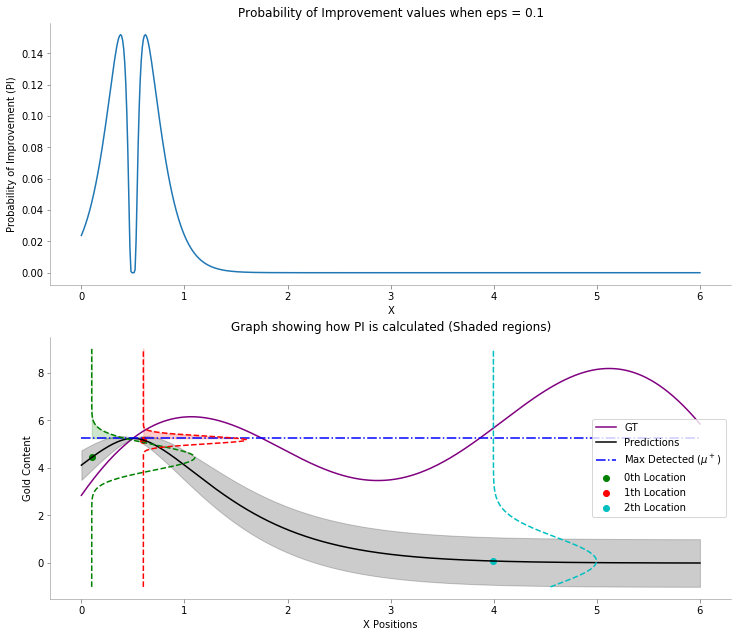

In [22]:
pi_cdf_plot(gp, x, train_X, train_y, x_locs=[0.10, 0.6, 4], eps=0.1)

`mu_plus` refers to the maximum functional value i.e., `max(train_y)`, where `train_y` refers to the gold content at the currently drilled locations. We see that the probability of improvement values are calculated by finding the functional value of the cumulative density function at `mu_plus`. The Gaussian parameters for each point are the mean and standard deviation predicted from Gaussian Process Regressor for that point.

#### Hyperparameter: Eps
Now we have the intuition behind how Probability of Improvement is calculated, now let's change `eps` and look at its effects.

In [23]:
eps = 0.01
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-.05, 1.05)),
    acq_params = acq_params
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps0.01.gif)

Looking at the graph above we can see that we are not effectively exploring at value `eps = 0.01` for the Probability of Improvement acquisition function. We are stuck.

In [24]:
eps = 0.5
acq_params = {
    'eps': eps
}

dirName, mtn_pi = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-.05, .1)),
    acq_params = acq_params,
    y1scale='log'
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps0.5.gif)

Looking above, we see increasing the value to `eps = 0.5` enables us to explore more and get to the maximum value which we wanted in the case of Multi-arm bandit problem. One can notice that values at $x \in [3, 4.5]$ posses uncertainty (can be identified by the grey translucent area, but as we remember we are not interested in getting the best prediction of the gold distribution, we only care about the maximum value that we can achieve, which this acquisition function with given hyper-parameters is able to capture nicely!

Let's look at what happens if we increase the hyper-parameter `eps` a bit more.

In [25]:
eps = 3
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    PI, ylim1=((-.05, 1.05)),
    y1scale='log', acq_params = acq_params
)

# gify
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-pi-eps{eps}.gif

![](MAB_gifs/mab-gp-pi-eps3.gif)

We see that we made things worse! Our model now uses `eps = 3` which has effectively resulted in way too much exploratoration. This amount of exploration is not able to exploit when we land somewhere near a global maxima.

----

### Expected Improvement (EI)

Probability of improvement only looked at `how likely` is an improvement, but, shouldn't we be looking into `how much` we can improve. The next criterion called Expected Improvement (EI) looks into both :)

\begin{equation}
    EI(x)=
    \begin{cases}
      (\mu(x) - \mu^+ - \epsilon)\Phi(Z) + \sigma(x)\phi(Z), & \text{if}\ \sigma(x) > 0 \\
      0 & \text{if}\ \sigma(x) = 0 
    \end{cases}
  \end{equation}
 $$Z= \frac{\mu(x) - \mu^+ - \epsilon}{\sigma(x)}$$
 where $\Phi(.)$ indicates CDF and $\phi(.)$ indicates pdf

In [26]:
class EI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        mu: max value of y among the selected train_pts
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        z = (y_pred - mu - eps)/sigma
        return (y_pred - mu - eps)*ndtr(z) + sigma*norm.pdf(z)

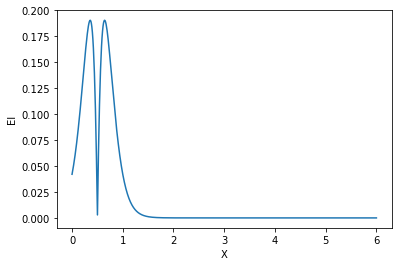

In [27]:
p = EI()
gp.fit(train_X, train_y)
mu_plus = max(train_y)
plt.plot(x, 5*p(gp, x, mu=mu_plus, eps=0))
plt.ylabel(f"{p}")
plt.xlabel("X");

In [28]:
eps = 0.01
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((-0.001, .05)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps0.01.gif)

Like the Probability of Improvement's acquisition function, we can moderate the amount of explorability the Expected Improvement's acquisition function by setting the `eps` hyper-parameter. 

We see that having `eps = 0.01` primarily results in exploitation, and we are not able to get to the global maxima due to this myopic drilling location selection.

Let's try increasing the `eps` variable to focus a little more on exploribility.

In [29]:
eps = 1.5
acq_params = {
    'eps': eps
}

dirName, mtn_ei = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((-0.001, .05)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps1.5.gif)

As we expected, increasing the value to `eps = 1.5` makes the acquisition function explore more and exploit when the time comes. We see that it moves slowly once it reaches near the global maxima, trying to find the global maxima. In this case, the exploration is effectively helping us reach a higher functional value much earlier!

Let's see if increasing `eps` helps us more!

In [30]:
eps = 3
acq_params = {
    'eps': eps
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    EI, ylim1=((-0.001, .05)),
    acq_params=acq_params,
    y1scale='log'
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei-eps{eps}.gif

![](MAB_gifs/mab-gp-ei-eps3.gif)

Is this better than before? Turns out a yes and a no. We see that here we do too much exploration given the value of `eps = 3`. Which results in early reaching something close to global maxima, but unfortunately we don't exploit to get more gains near the global maxima. We would have liked an acquisition function that tried to exploit a bit more after reaching somewhere close to the global maxima. In essence:
- reach near global maxima in a lower number of iterations
- we don't exploit once we reach near global maxima

---

In [31]:
def ei_pi_plot(
        train_X, train_y, i,
        ylim=None, xlim=None,
        yscale='log', xscale='log',
        seed = 2,
        pi_params={}, ei_params={},
    ):
    np.random.seed(seed)
    
    fig, ax = plt.subplots()
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)

    # fitting
    gp.fit(train_X, train_y.flatten())

    # for plotting scatter plot
    pi_obj = PI()
    ei_obj = EI()
    pi_acq = pi_obj(gp, x, **pi_params, mu=max(train_y))
    ei_acq = ei_obj(gp, x, **ei_params, mu=max(train_y))
    
    # predict on current pool set
    y_pred, sigma = gp.predict(x, return_std=True)
    ax.scatter(pi_acq, ei_acq, color='black', alpha=0.4, label='Location')
    ax.set_ylabel('EI_acq value')
    ax.set_xlabel('PI_acq value')
    pi_hyperparams = ': HParam(s) → '+' | '.join([str(k)+': '+str(v) for k, v in pi_params.items()])
    ei_hyperparams = ': HParam(s) → '+' | '.join([str(k)+': '+str(v) for k, v in ei_params.items()])
    
    # limits
    ax.set_ylim(ylim) if ylim is not None else None # ax.set_ylim(min(ei_acq), max(ei_acq)
    ax.set_xlim(xlim) if xlim is not None else None # ax.set_xlim(min(pi_acq), max(pi_acq))
    
    strr = str(pi_obj) + pi_hyperparams + '\n' + str(ei_obj) + ei_hyperparams
    ax.set_title(strr)

    ax.legend(bbox_to_anchor=(1.1,1), loc="upper left")
    format_axes(ax)
    
    pii = list(map(str, pi_params.values()))
    eii = list(map(str, ei_params.values()))
    params_str = '-'.join(pii + eii)
    dirName = './MAB_gifs/Ei_Pi_graph/'
    os.makedirs(dirName, exist_ok=True)
    plt.savefig(f"{dirName}/{i}.svg", bbox_inches="tight")
    plt.close()
    return (dirName)

In [32]:
pi_eps = [0.01]#, 0.001, 0.01, 0.1, 1]
ei_eps = [0.01]#, 0.001, 0.01, 0.1, 1]

for i, (pi_ep, ei_ep) in enumerate(zip(pi_eps, ei_eps)):
    pi_params = {'eps': pi_ep}
    ei_params = {'eps': ei_ep}

    dirName = ei_pi_plot(
        train_X, train_y, i,
        pi_params = pi_params,
        ei_params = ei_params,
        yscale='linear', xscale='linear',
        ylim=(0, 0.05), xlim=(0, .5),
    )

# gify!
# !convert -delay 50 -loop 0 {dirName}/*.png {gifDir}/ei_pi_graph.gif

We have seen two closely related methods, The _Probability of Improvement_ and the _Expected Improvement_. We can think of these two to be related to the ideas that we commonly are familiar with `risk` and `gain` respectively.

It seems natural to see how these metrics change for each of the points. We have plotted the values for both policies' acquisition function's values below, for each of the possible locations. The graph shows the relation followed between EI and PI for when we have a single training point `(0.5 f(0.5))`. 

![](MAB_gifs/Ei_Pi_graph/0.svg)

If we look closely, we can see if we have an equal estimated improvement as in the case with the points with `EI(x) = 0.4` it would be more beneficial to differentiate between these points which have a better value for Probability of Improvement. In other words, when `gain`s are the same, we should prioritize to choose the option with lesser `risk`. And similarly, when the `risk`s are similar, we would likely want to go with points with greater `gain`s.

---

### Gaussian Process Upper Confidence Bound (GP_UCB)

GP_UCB is another formulation for acquisition function where we also have theoretical bounds on the number of iterations taken to reach near global maximum.

### Gaussian Process Upper Confidence Bound (GP_UCB)

In [33]:
class GP_UCB(ACQ):
    def acq_fn(self, gp_reg, x, t, mu=5.,
               v = 1., delta=1., **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        t: Iteration number (1, ..)
        """
        d = x.shape[1]
        y_pred, sigma = gp_reg.predict(x, return_std=True)    
        k = np.sqrt( v* (2*  np.log( (t**(d/2. + 2))*(np.pi**2)/(3. * delta)  )))
        return y_pred + k*sigma

In [34]:
acq_params = {
    'v': 1,
    'delta': 1
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb1-1.gif

![](MAB_gifs/mab-gp-gp_ucb1-1.gif)

We seem to be exploiting too much , let's increase the exploratory hyperparameters!

In [35]:
acq_params = {
    'v': 3,
    'delta': 1
}

dirName, mtn_gp_ucb = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb3-1.gif

![](MAB_gifs/mab-gp-gp_ucb3-1.gif)

Using this set of hyper-parameters, we are able to get near global maxima and further "exploit" to find the global maximum. This was a result of increasing the value of `v` to `3`; this shows that `v` gives weightage to exploration.

In [36]:
acq_params = {
    'v': 1,
    'delta': 3
}

dirName, _ = plot_acquisition(
    train_X, train_y,
    GP_UCB, ylim1=((0, 10)),
    acq_params=acq_params,
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-gp_ucb1-3.gif

![](MAB_gifs/mab-gp-gp_ucb1-3.gif)

Setting the values of the hyperparameters  to `v = 1` and `delta = 3` results a greater exploitation.

---

### Probability of Improvement + $\lambda \  \times$ Expected Improvement (EI_PI)

Below we have tried to combine PI and EI using a linear combination as a combination of various acquisition function also results in an acquisition function. We can, therefore, combine any of the acquisition function and form a new one.

In [38]:
class EI_PI(ACQ):
    def acq_fn(self, gp_reg, x, mu=5., eps_pi=0.01, eps_ei=0.01, lam=.3, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        
        # ei
        z = (y_pred - mu - eps_ei)/sigma
        ei_acq = (y_pred - mu - eps_ei)*ndtr(z) + sigma*norm.pdf(z)
        
        # pi
        pi_acq = ndtr((y_pred - mu - eps_pi)/sigma)
        return pi_acq + lam * ei_acq

In [39]:
acq_params = {
    'eps_pi': .2,
    'eps_ei': .4,
    'lam': 1,
}

dirName, mtn_ei_pi = plot_acquisition(
    train_X, train_y,
    EI_PI, ylim1=((0, 10)),
    acq_params=acq_params,
    y1scale='log',
)

# gify!
!convert -delay 40 -loop 0 {dirName}/*.png {gifDir}/mab-gp-ei_pi.gif

![](MAB_gifs/mab-gp-ei_pi.gif)

### Comparison between all the methods

Below we have a graph showing a comparison between the methods discussed above. We have chosen the hyper-parameters that gave us the best performance during our basic hyper-parameter search.

We see the _Random_ method is able to find the maximum much before any of the other methods, this can be seen when we are faced with smaller spaces to find the global maximum. If we have more dimensions to `x`, searching in this space would not be so easy using random, due to what we call the curse of dimensionality.

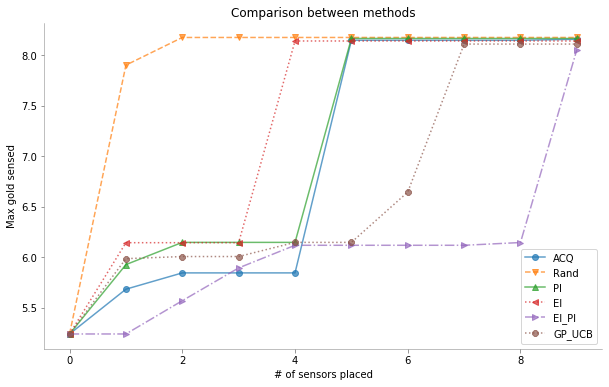

In [41]:
mtns = [mtn_acq, mtn_rand, mtn_pi, mtn_ei, mtn_ei_pi, mtn_gp_ucb]
names = ['ACQ', 'Rand', 'PI', 'EI', 'EI_PI', 'GP_UCB']
markers = ['o-', 'v--', '^-', '<:', '>-.', '8:']

xx = range(len(mtns[0]))
plt.figure(figsize=(10, 6))
for n, m, mm in zip(names, mtns, markers):
    plt.plot(xx, m, mm, label=n, alpha=0.7)
plt.legend()
plt.xlabel('# of sensors placed')
plt.ylabel('Max gold sensed')
plt.title('Comparison between methods')
format_axes(plt.gca())
plt.savefig("MAB_gifs/", bbox_inches="tight")
plt.show()

## Observation

We see that the plots above show the maximum gold content detected for the case of multi-arm bandit problem vs. the number of holes drilled. Looking at the graph above we can see that for our problem Probability of Improvement performed the best among all the variants of Acquisition functions.


## Conclusions
We see that for the case of multi-arm bandit we have a bit different problem as compared to the active learning problem and therefore we have the different objective functions that we try to maximize for the query points.

### Caution
We need to take care while using Bayesian Optimization

- Scale of the features
- Kernel selection for Guassian Process

#### Aknowledgments

- Nando de Freitas

- Thomas Huijskens PyData Talk - Bayesian optimisation with scikit-learn https://www.youtube.com/watch?v=jtRPxRnOXnk

## Hyperparameter Search
For now we have been looking at single dimensional function, i.e. $f: \mathbb{R} \texttt{ -> } \mathbb{R}$ data where we needed to find the value of $\boldsymbol{x}$ where we reached global maximum. Let's move on and try to tackle real-valued functions of $n$ real variables functions, i.e. $f: \mathbb{R}^n \texttt{ -> } \mathbb{R}$. We will soon see that our methods that we saw earlier for the single dimensional case can be easily ported for baesian optimization on multi-variable functions.

Let's take an example of sk-learn's moons dataset.

In [762]:
from sklearn.datasets import make_moons
from sklearn.svm import SVC
import matplotlib as mpl
from sklearn.model_selection import train_test_split

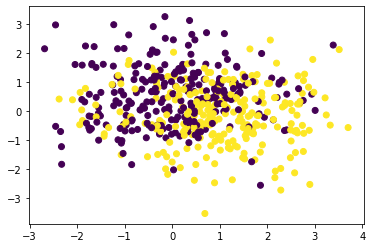

In [763]:
seed = 0
X, y = make_moons(n_samples=500, shuffle=True, noise=1, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

plt.scatter(X[:, 0], X[:, 1], c = y)

In [846]:
def f(Gammas, Cs):
    '''Given a grid of hyperparameters we fit the SVM and return
    the accuracy'''
    shp = Cs.shape
    Gammas, Cs = Gammas.flatten(), Cs.flatten()
    assert (Gammas.shape == Cs.shape)
    accs = []
    for gamma, C in zip(Gammas, Cs):
        clf = SVC(gamma=gamma, C=C, random_state=seed)
        clf.fit(X_train, y_train)
        pred_y = clf.predict(X_test)
        mask = (pred_y == y_test)
        acc = mask.sum()/mask.shape[0]
        accs.append(acc)
    return np.array(accs).reshape(shp)

In [848]:
x0 = np.linspace(0.01, 10, 50) # gammas
x1 = np.linspace(0.01, 20, 100) * 1.7# Cs

X0, X1 = np.meshgrid(x0, x1)

GT = f(X0, X1)
print('GT.shape:', GT.shape)

GT.shape: (100, 50)


In [849]:
import sys

In [853]:
# getting one training sample
g = np.array([5, 4])
c = np.array([10])
G0, C1 = np.meshgrid(g, c)
train_y = f(G0, C1)
train_y
print(G0, C1)
print(train_y)

[[5 4]] [[10 10]]
[[0.58 0.62]]


In [863]:
def getPoints(a, b):
    '''Returns points in meshgrid'''
    pts = np.concatenate([a.flatten().reshape(-1, 1), 
                          b.flatten().reshape(-1, 1)], 
                         axis=1)
    return pts

In [854]:
def plot_acquisition3d(
        G0, C1, train_y,
        acq_class, acq_params={},
        z0lim = (0.5, 1), z1lim = None,
        it = 10, seed = 0, levels=30, drawedges=True,
        debug=True
    ):
    """acq_params would contain the parameters for our acq_fn"""
    np.random.seed(seed)
    # for storing the max till it iters
    max_till_now = []
    
    # Stopping criteria is 10 iterations
    for i in range(it):
        fig, ax = plt.subplots(ncols=2, figsize=(16,6))
        for a in ax:
            a.set_aspect('equal')
        # 0 GT
        # 1 Acqui
        
        ax[0].set_ylim((0), max(x[:, 1])) # C
        ax[0].set_xlim((0), max(x[:, 0])) # gamma
        ax[1].set_ylim((0), max(x[:, 1]))
        ax[1].set_xlim((0), max(x[:, 0]))
        
        # fitting
        gp.fit(getPoints(G0, C1), train_y.flatten())
        
        # plot ground truth
        boun0 = np.linspace(*z0lim, levels)
        h = ax[0].contourf(X0, X1, GT, cmap='plasma', 
                           levels=levels, 
                           vmin=z0lim[0], 
                           vmax=z0lim[1])
        m = plt.cm.ScalarMappable(cmap='plasma')
        m.set_array(GT)
        m.set_clim(*z0lim)
        plt.colorbar(m, drawedges=drawedges, boundaries=boun0, ax=ax[0])
        # plot current training set
        ax[0].scatter(train_X[:, 0], train_X[:, 1], color='white', s=30,
                      zorder=10, label='Train points')
        
        ax[1].scatter(train_X[:, 0], train_X[:, 1], color='white', s=30,
                      zorder=10, label='Train points')
        if debug:
            print ('first point:', train_X[:, 0], train_X[:, 1])
        
        # plot Acquisition
        acq_obj = acq_class()
        acquisition = acq_obj(gp, x, t=i+1, **acq_params, mu=max(train_y))
        if debug:
            print('acquisition', acquisition.shape)
            print('gp.copy_X_train: ', gp.X_train_)
            print('acq function near last train point:')
        h2 = ax[1].contourf(X0, X1, 
                            acquisition.reshape(X0.shape), 
                            cmap='plasma', 
                            levels=levels)        
        plt.colorbar(h2, ax = ax[1], drawedges=drawedges)
        
        hyperparams = ' | '.join([str(k)+': '+str(v) for k, v in acq_params.items()])
        ax[1].set_title(f"{acq_obj} & It: {i} & HParam(s) → " + hyperparams)
        ax[1].set_xlabel("Gamma Values")
        ax[1].set_ylabel("C Values")
        
        # Choose the next point with highest acq
        max_mu = max(train_y.flatten())
        max_till_now.append(max_mu)
        next_ix = rargmax(acquisition.flatten())
        n_x = x[next_ix, :]
        

        # Add new point with highest uncertainty to the pool set
        train_X = np.vstack([train_X, [x[next_ix]]])
        train_y = f(train_X)

        # Add new point with highest uncertainty to the pool set
        ax[1].scatter(n_x[0], n_x[1], marker='X',s=50,
                      c='grey', zorder=1,
                      label='maxima (tie randomly broken)')
        ax[0].scatter(x[next_ix, 0], x[next_ix, 1], color='grey',
                      s=200, zorder=10, label='Query Point')
        ax[0].set_xlabel("Gamma Values")
        ax[0].set_ylabel("C Values")
        ax[0].set_title("Accuracies (Not Known)")
        ax[0].legend(bbox_to_anchor=(0,1), loc="upper left", framealpha=0.3)
        ax[1].legend(bbox_to_anchor=(0,1), loc="upper left", framealpha=0.3)

        acq_params_str = '-'.join(list(map(str, acq_params.values())))
        dirName = './MAB_pngs/'+str(acq_obj)+'3d/'+acq_params_str
        os.makedirs(dirName, exist_ok=True)
        plt.savefig(f"{dirName}/{i}.png", bbox_inches="tight", dpi=300)
        plt.show()
#         plt.close()
    return dirName, max_till_now, train_X

In [841]:
# Code is heavily borrowed from: https://modal-python.readthedocs.io/
# en/latest/_modules/modAL/acquisition.html#max_PI
class PI(ACQ):
    def acq_fn(
        self, gp_reg, x, mu=5., eps=0.01, **kwargs):
        """
        gp_reg: sklearn.GPRegresssor
        """
#         print (x)
        y_pred, sigma = gp_reg.predict(x, return_std=True)
        cdf = ndtr((y_pred - mu - eps)/sigma)
        return cdf

first point: [5] [10]
acquisition (5000,)
gp.copy_X_train:  [[ 5 10]]
acq function near last train point:


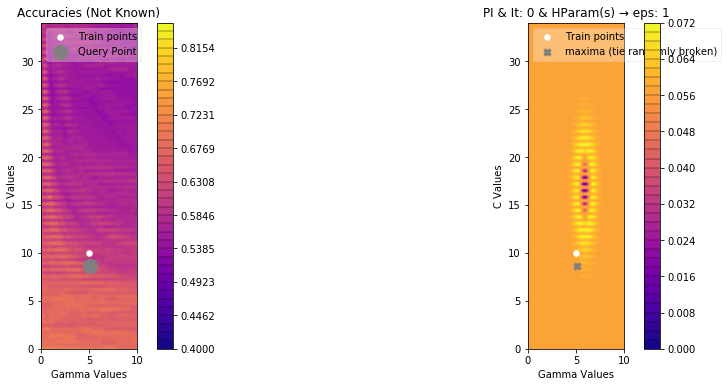

first point: [5.         5.10693878] [10.          8.59856566]
acquisition (5000,)
gp.copy_X_train:  [[ 5.         10.        ]
 [ 5.10693878  8.59856566]]
acq function near last train point:


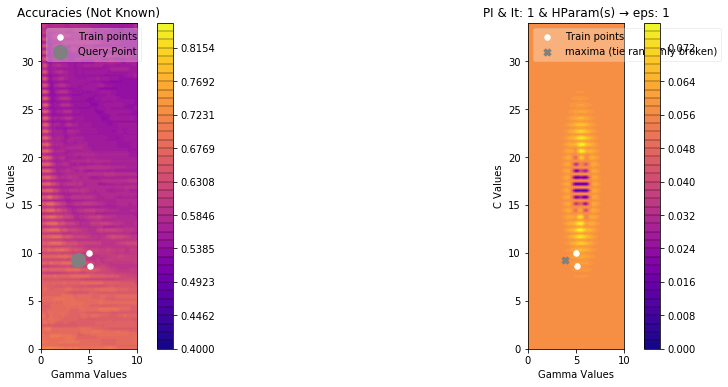

first point: [5.         5.10693878 3.88367347] [10.          8.59856566  9.28509091]
acquisition (5000,)
gp.copy_X_train:  [[ 5.         10.        ]
 [ 5.10693878  8.59856566]
 [ 3.88367347  9.28509091]]
acq function near last train point:


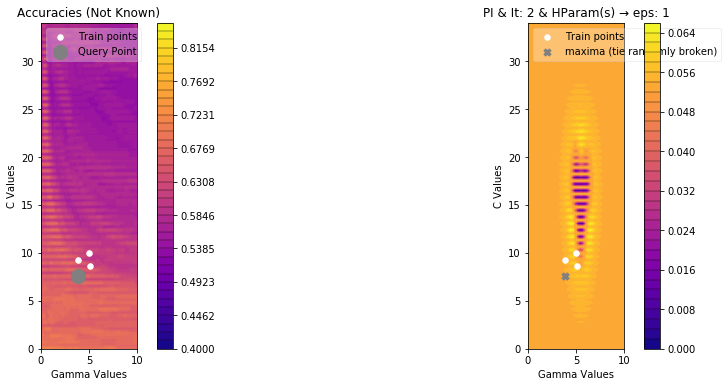

first point: [5.         5.10693878 3.88367347 3.88367347] [10.          8.59856566  9.28509091  7.56877778]
acquisition (5000,)
gp.copy_X_train:  [[ 5.         10.        ]
 [ 5.10693878  8.59856566]
 [ 3.88367347  9.28509091]
 [ 3.88367347  7.56877778]]
acq function near last train point:


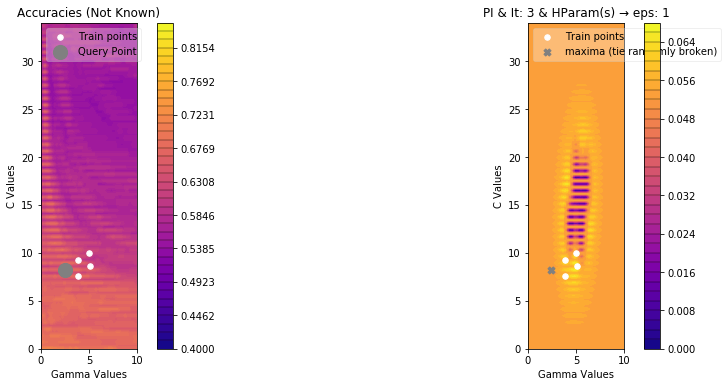

('./MAB_pngs/PI3d/1',
 [0.58, 0.58, 0.61, 0.61],
 array([[ 5.        , 10.        ],
        [ 5.10693878,  8.59856566],
        [ 3.88367347,  9.28509091],
        [ 3.88367347,  7.56877778],
        [ 2.45653061,  8.25530303]]))

In [842]:
acq_params = {'eps':1}
plot_acquisition3d(train_X, train_y, 
                   PI, acq_params=acq_params,
                   z0lim=(.4, 0.85),
                   it=4, levels=40)

In [ ]:
# gp = GaussianProcessRegressor()
# gp.fit(x[:2], f(x[:2]))

bhncofdddd x is not mesh same'

In [740]:
a = np.linspace(1, 4, 2)
b = np.linspace(3, 6, 3)

x = np.array(list(itertools.product(a, b)))
print(x)

X0, X1 = np.meshgrid(a, b)

print('X0:', X0)
print('X1:', X1)

[[1.  3. ]
 [1.  4.5]
 [1.  6. ]
 [4.  3. ]
 [4.  4.5]
 [4.  6. ]]
X0: [[1. 4.]
 [1. 4.]
 [1. 4.]]
X1: [[3.  3. ]
 [4.5 4.5]
 [6.  6. ]]


In [689]:
f(x)

array([0.67, 0.67, 0.67, 0.64, 0.62, 0.58])

In [690]:
p = PI()
p(gp, x)

[[1.  3. ]
 [1.  4.5]
 [1.  6. ]
 [4.  3. ]
 [4.  4.5]
 [4.  6. ]]


array([3.16789524e-07, 2.76688515e-07, 2.72164426e-07, 2.72240371e-07,
       2.72152802e-07, 2.72150185e-07])

[array([1., 3.])]
[2.0092205e-06]
[array([1. , 4.5])]
[0.]
[array([1., 6.])]
[2.0092205e-06]
[array([4., 3.])]
[2.82489312e-07]
[array([4. , 4.5])]
[3.04896113e-07]
[array([4., 6.])]
[2.82489312e-07]


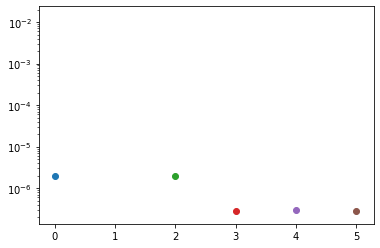

In [691]:
gp = GaussianProcessRegressor()
gp.fit([[1, 4.5]], [2])
for i, aa in enumerate(aaa):
    p = PI()
    ss = p(gp, [aa])
    print (ss)
    plt.scatter(i, ss)
    plt.yscale('log')